In [22]:
import os
from fastai.vision.all import *
from fastcore.xtras import Path
from fastai.data import *
import fastai
import torch
import json


In [23]:
torch.cuda.is_available() # Check if GPU is available

True

In [24]:
# Enables IPython widgets
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

### **Get all files**

In [25]:
label = 'linje'
local_path = 'O:\Dataingeniør Bachelor\\6. Semester\DAT255\course-project'
data_path = local_path + '/data/self-collected'
mask_path = data_path + f'/labels/{label}'
image_path = data_path + f'/images'

valid_path = data_path + f'/val/valid.txt'
codes_path = data_path + f'/val/codes.json'

def _get_file_names(path):
    '''
    @param path
    @return list of filenames
    '''
    return [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]


get_msk = lambda o: Path(f'{mask_path}\\{o}')
get_img = lambda o: Path(f'{image_path}\\{o}')

In [26]:
imgs_fns = _get_file_names(image_path)
valid_fns = Path(valid_path).read_text().split('\n')

codes = json.load(open(codes_path)).get(label)

In [27]:
# img_fn = imgs_fns[0]
# mask = PILMask.create(get_msk(img_fn))
# img = PILImage.create(image_path + '/' + img_fn)
# mask.show()
# img.show()
# print(tensor(mask)[0])
# print(mask)

Need binary mask.

-> [random.ipynb](random.ipynb)

Fixed

In [28]:
def _file_splitter(fn):
    '''
    File splitter for self defined validation set
    @param fns: file path to .txt file with image names
    '''
    valid = Path(fn).read_text().split('\n') 
    def _func(x): return x in valid
    def _inner(a, **kawrgs): return FuncSplitter(_func)(a)
    return _inner

In [29]:
linje = DataBlock(blocks=(ImageBlock, MaskBlock(codes)), 
    get_items=_get_file_names, 
    splitter= RandomSplitter(valid_pct=0.2),
    get_y = get_msk,
    get_x = get_img,
    #Ratioresize could not work for me. Resizes, but keeps aspectratio
    item_tfms=Resize(348, 224),
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats, cuda=True)],)

In [30]:
dls = linje.dataloaders(source=image_path, device=torch.device('cuda'), bs=6)

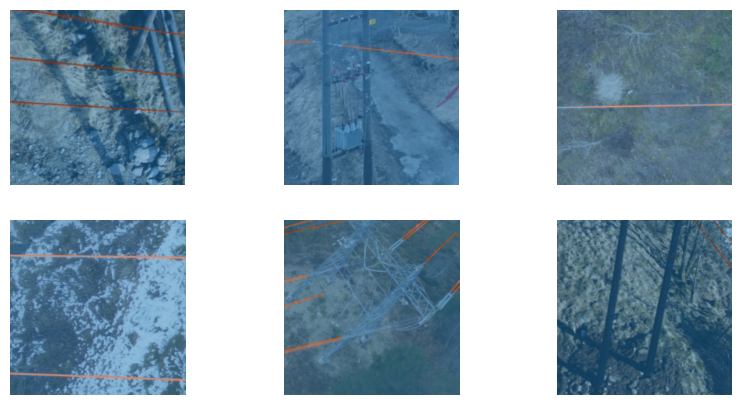

In [31]:
dls.show_batch(figsize=(10, 5))

In [11]:
learn = unet_learner(dls, arch=resnet34, pretrained=True)

o:\Dataingeniør Bachelor\6. Semester\DAT255\course-project\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
o:\Dataingeniør Bachelor\6. Semester\DAT255\course-project\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
learn.fine_tune(50)

epoch,train_loss,valid_loss,time
0,0.179931,0.165622,00:05
1,0.162771,0.148125,00:06
2,0.145717,0.119130,00:04
3,0.132769,0.142604,00:04
4,0.124183,0.113357,00:04
5,0.117672,0.101950,00:03
6,0.111154,0.096314,00:03
7,0.105800,0.096935,00:03
8,0.098682,0.103121,00:03
9,0.093805,0.097896,00:03


In [14]:
learn.fine_tune(50)

epoch,train_loss,valid_loss,time
0,0.061922,0.115196,00:04
1,0.050920,0.077525,00:04
2,0.046087,0.072554,00:03
3,0.044744,0.075832,00:03
4,0.042740,0.087303,00:03
5,0.040878,0.085048,00:04
6,0.039695,0.079423,00:04
7,0.039727,0.092019,00:04
8,0.038792,0.091103,00:04
9,0.039239,0.095795,00:04


In [16]:
learn.fine_tune(50)

epoch,train_loss,valid_loss,time
0,0.030124,0.078731,00:05
1,0.031278,0.079038,00:04
2,0.031121,0.085707,00:04
3,0.031202,0.085381,00:03
4,0.030859,0.085821,00:03
5,0.030239,0.082498,00:03
6,0.029533,0.079627,00:03
7,0.029575,0.097665,00:03
8,0.030458,0.114452,00:03
9,0.030601,0.074190,00:03


In [18]:
learn.fine_tune(50)

epoch,train_loss,valid_loss,time
0,0.031218,0.087134,00:04
1,0.030127,0.085934,00:04
2,0.029183,0.077409,00:03
3,0.028650,0.080413,00:03
4,0.028618,0.088671,00:03
5,0.028409,0.081698,00:03
6,0.028601,0.092789,00:03
7,0.028377,0.087720,00:03
8,0.028290,0.083568,00:03
9,0.027926,0.091083,00:03


In [20]:
learn.fine_tune(50)

epoch,train_loss,valid_loss,time
0,0.027304,0.079244,00:03
1,0.025971,0.081490,00:03
2,0.026180,0.100550,00:03
3,0.026235,0.092965,00:03
4,0.026402,0.088252,00:03
5,0.026034,0.097092,00:03
6,0.025587,0.093420,00:03
7,0.025513,0.074940,00:03
8,0.025560,0.097956,00:03
9,0.025725,0.095337,00:03


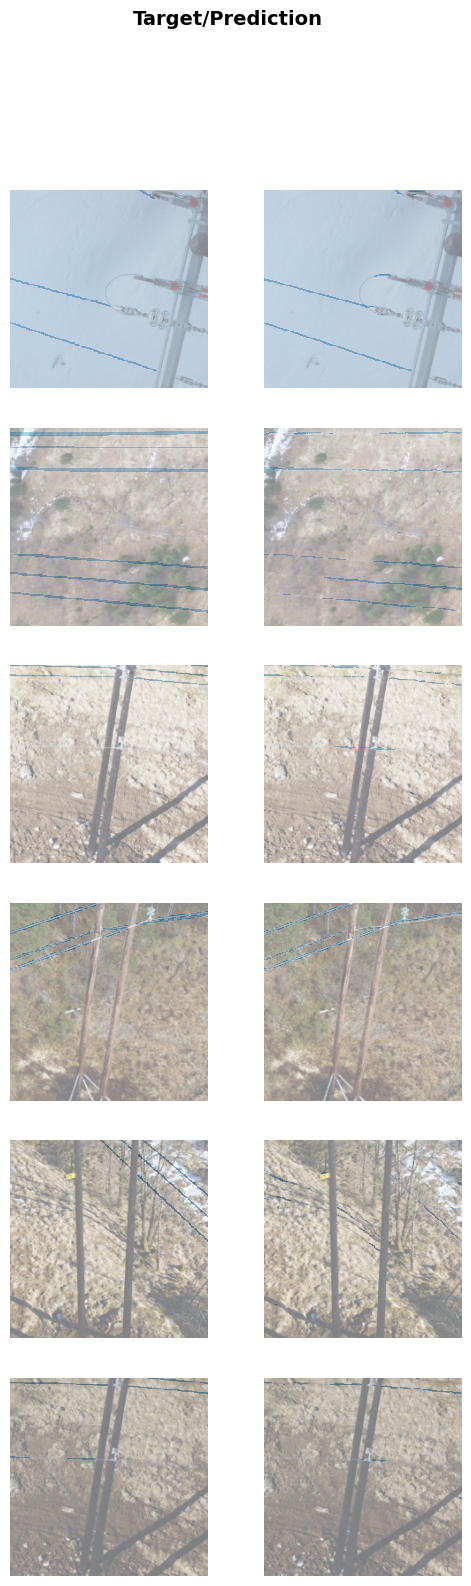

In [21]:
learn.show_results(cmap='Blues', vmin=0, vmax=2)

In [28]:
preds = learn.get_preds()
p = preds[0][3]

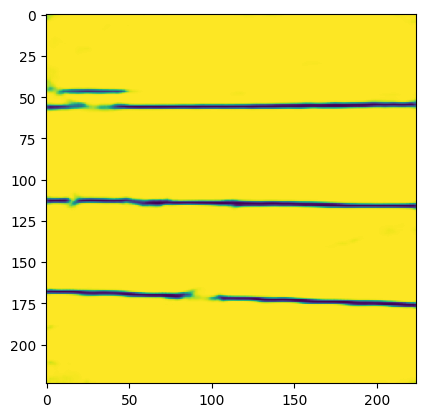

In [29]:
plt.imshow(p[0])

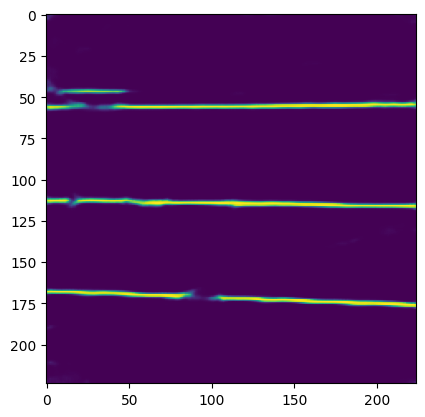

In [30]:
plt.imshow(p[1])

In [ ]:
setup_cuda(benchmark=True)

In [ ]:
torch.cuda.empty_cache()

In [31]:
learn.save("unet-resnet-34-linje-100-epochs", with_opt=True)

Path('models/unet-resnet-34-linje-100-epochs.pth')